# Paragon Sales Analysis and Forecasting
 
Gabriel Reyes - FTDS 004

# 1. Packages

In [275]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

import datetime
import pendulum
import nbformat 
from scipy import stats

# Time Series Statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams

# Outlier Handling
from feature_engine.outliers import Winsorizer

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score


# 2. Data Loading and Overview

In [141]:
# Importing Dataset
df = pd.read_csv('dataset.csv')

# Changing to DateTime Format
col = ['week_start_date','week_end_date']

for i in col :
    df[i] = pd.to_datetime(df[i])
    print(df[i].dtypes)

datetime64[ns]
datetime64[ns]


In [142]:
# Updating the Week Number column into datetime object format
# Showing only the year and week of the dataset
df['week_number'] = pd.to_datetime(df['week_number'] + '-0', format='%Y-%W-%w').dt.strftime('%Y-%W')

In [143]:
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   week_number      102733 non-null  object        
 1   week_start_date  102733 non-null  datetime64[ns]
 2   week_end_date    102733 non-null  datetime64[ns]
 3   product_item     102731 non-null  object        
 4   quantity         102733 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 3.9+ MB


In [145]:
df['week'] = pd.to_datetime(df['week_number'] + '-1', format='%Y-%W-%w').dt.week

C:\Users\appsg\AppData\Local\Temp\ipykernel_2532\1971920121.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [146]:
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52


In [147]:
df[df['week_end_date'].dt.year == 2023]

,week_number,week_start_date,week_end_date,product_item,quantity,week
79942,2023-00,2022-12-26,2023-01-01,0065e8b533cd2c8273529312a6e8f219,27,52
79943,2023-00,2022-12-26,2023-01-01,0073377087c7ddace313ff829cd7b0b3,26,52
79944,2023-00,2022-12-26,2023-01-01,0098d23d332c193a07eabaf0f703d4e5,2838,52
79945,2023-00,2022-12-26,2023-01-01,009e12e8fd2ef0b77047206e939fc6b9,1418,52
79946,2023-00,2022-12-26,2023-01-01,00b21b77bbe70ca3b33125402cfaa7b4,49,52
...,...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907,14
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81,14
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16,14
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920,14


In [148]:
df.tail()

,week_number,week_start_date,week_end_date,product_item,quantity,week
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907,14
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81,14
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16,14
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920,14
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53,14


# 3. Exploratory Data Analysis

In [149]:
# Cloning the initial dataset
eda = df.copy()
eda.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52


## Business Objective

To start with data analysis, let's get back to the root of the objectives.

Firstly first, The Dataset is provided by ParagonCorp. According to the overview of the dataset above, the dataset talks about the transaction from ParagonCorp businesses from 2022-2023.

#### **Who is ParagonCorp ?**

<center><img src="Pictures\Paragon.jpg" style="width:70%;height:70%;"></center>

Paragon is an Indonesian beauty company. Paragon was founded back in 1985 with the name of **PT. Pusaka Tradisi Ibu**. Their first brand is called "Putri". 

In 1999, The Paragon factory received Halal certification from LPPOM UI, with `Wardah` as the pioneer of the Halal brand in Indonesia, and received an award from the World Halal Council.

In 2011, **PT Pusaka Tradisi Ibu** changed its name to **PT Paragon Technology** and Innovation. Since then, Paragon is becoming one of Indonesia's most well-known companies in beauty products.

Today, Paragon has 41 distribution centres, more than 200 CSR Partners, and more than 1600 SKU Products.


#### So then, **What is Time Series Analysis?**

According to Brockwell in his writing in the International Encyclopedia of Education, Time series analysis has many different objectives, depending on the field of application. 

These include forecasting future values of the series, extracting a signal hidden in noisy data, discovering the mechanism by which the data are generated, simulating independent realizations of the series to see how it might behave in the future (and hence, for example, to estimate the probability of extreme events like floods), and eliminating the seasonal component from data sets to reveal more clearly the underlying trend.

https://www.sciencedirect.com/topics/neuroscience/time-series-analysis

### Business Objecive

Building an analysis and model to help Paragon to :

- Forecast Future Sales
- Improve Inventory Management
- Improve Resource Allocation
- Create Marketing Strategies

## Time Related Features

## Week of Month

First, I will extract the week number in a month from each date range. The objective of this work is that we may find unique pattern accross the week in a month

In [150]:
# Extracting the Week of Month value using Pendulum packages
eda['week_month'] = eda['week_end_date'].apply(lambda x: pendulum.parse(str(x)).week_of_month)
eda['week_month'].value_counts()
# eda['week_month'] = eda['week_month'].replace({-50: 2, -49: 3, -48: 4, -47: 5})

 1     23872
 2     21540
 3     20240
 4     20163
 5      4773
-50     3150
-49     3037
-48     2982
-47     2976
Name: week_month, dtype: int64

There is something wrong with the parsing result, since there are week of -50, -49, -48, and -47. I will take a look closer to each of the wrong result

In [151]:
a = eda[eda['week_month']== -50]
b = eda[eda['week_month']== -49]
c = eda[eda['week_month']== -48]
d = eda[eda['week_month']== -47]

col = [a,b,c,d]

for i,j in enumerate(col) :
    print('Unique date : {}'.format(j['week_start_date'].nunique()))
    print(j[['week_start_date','week_end_date']].iloc[[0,-1]])
    

Unique date : 2
      week_start_date week_end_date
450        2022-01-03    2022-01-09
83171      2023-01-02    2023-01-08
Unique date : 2
      week_start_date week_end_date
1951       2022-01-10    2022-01-16
84731      2023-01-09    2023-01-15
Unique date : 2
      week_start_date week_end_date
3428       2022-01-17    2022-01-23
86233      2023-01-16    2023-01-22
Unique date : 2
      week_start_date week_end_date
4908       2022-01-24    2022-01-30
87738      2023-01-23    2023-01-29


The error occurred in the January period, do check the January period. It is probably occurred to the dates that is overlapping with the December of the previous year.

In [152]:
eda[eda['week_end_date']== '2022-01-02'].head(3)

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1


In [153]:
eda[eda['week_end_date']== '2023-01-01'].head(3)

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month
79942,2023-00,2022-12-26,2023-01-01,0065e8b533cd2c8273529312a6e8f219,27,52,1
79943,2023-00,2022-12-26,2023-01-01,0073377087c7ddace313ff829cd7b0b3,26,52,1
79944,2023-00,2022-12-26,2023-01-01,0098d23d332c193a07eabaf0f703d4e5,2838,52,1


From both entries above, the overlapping date are counted as the week 1 on the month of the week_end_date. So then, the rest of the date will be changed accordingly (2,3,4,5)

Week Month :

-50 = 2

-49 = 3

-48 = 4

-47 = 5

In [154]:
eda['week_month'] = eda['week_month'].replace({-50:2, -49:3, -48:4, -47:5})
eda['week_month'].value_counts()

2    24690
1    23872
3    23277
4    23145
5     7749
Name: week_month, dtype: int64

The week month label has been changed into 1 - 5. This number will be used for exploratory of the time series

## Transactions

In the given dataset, there are 2 column that are explicitly describe the transaction related matters. There are `product_items` and `quantity`.

+ product_items : Information about the product item/ product code

+ quantity : Information about quantity of product in respective week

We will deep dive more into these columns


In [155]:
eda.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1


## Product Item

I will perceive the product item as the SKU.

`What is SKU ?`

In the world of retail-related acronyms, SKU stands for “stock keeping unit” and — as the name suggests — it is a number (usually eight alphanumeric digits) that retailers assign to products to keep track of stock levels internally. If a product has different colors and sizes, each variation has a unique SKU number.


<center><img src="Pictures\SKU.jpg" style="width:70%;height:70%;"></center>

In this section, we will try to focus to explore the product_item column

In [156]:
print('Total unique SKU : {}'.format(eda['product_item'].nunique()))
eda['product_item'].value_counts().sort_values(ascending=False).head(5).reset_index()

Total unique SKU : 2309


,index,product_item
0,0073377087c7ddace313ff829cd7b0b3,67
1,06ce7c1fbb10bdc3024ce939ac2ffab2,67
2,079e5dcf6f594f3f1fe67cd8d18f04ff,67
3,085cdb7d3712fe0105a076fc07060176,67
4,08e66e5ff8cc09a7dfdf3eb962c53ce4,67


There are 2309 SKU listed on the dataset.

According to [magestore](https://www.magestore.com/blog/how-to-create-sku-numbers/), there are some general pattern in creating the SKU Numbers.

1. Start with a top-level identifier

- The beginning of each SKU should represent a top-level identifier in 2-3 characters. This is the most general classification that a product belongs to. Top-level identifiers can be a department, product category, or supplier. Based on the identifier, you can quickly locate any products in your store at a glance.

2. Assign nuique identifier in the middle numbers

- Next, take the middle section of the SKUs to add unique features, such as size, color, subcategory to your item. Think about which product attributes are important to you and make sense when organizing your products.

3. Complete the SKU with a sequential number

- Use a sequential number to finish your SKU, like 001, 002, 003. It identifies older items versus newer items in your inventory and makes counting stock effortless. Therefore, no matter how many products you need to organize, the SKU lets you know which items have been in stock for longer and should be prioritized for promotion.

I will try to parse the top level identifier, by popping out the first 2 letters/numbers in the SKU code

In [157]:
# Popping out the first three characters in Product Item column
eda['identifier'] = eda['product_item'].str.slice(stop=2)
eda.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month,identifier
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1,00
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1,01
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1,01
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1,01
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1,01


In [158]:
print('Total unique SKU Identifier : {}'.format(eda['identifier'].nunique()))
eda['identifier'].value_counts().sort_values(ascending=False).head(5).reset_index()

Total unique SKU Identifier : 256


,index,identifier
0,0e,829
1,ed,788
2,60,776
3,e4,766
4,f4,731


There are 256 SKU identifier. It means that from total 2309 SKU listed on the dataset, there are 256 Top level identifier that may groups them into spesifict product categories.

## Exploratory

In [159]:
explore = eda.copy()
explore.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month,identifier
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1,00
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1,01
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1,01
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1,01
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1,01


In [160]:
explore['quantity'].sort_values(ascending=False).head()

59156    774732
55886    541135
57519    518658
33243    496556
34779    490140
Name: quantity, dtype: int64

### Transactions

In [161]:
explore["year"] = explore['week_end_date'].dt.year
explore["month"] = explore['week_end_date'].dt.month
fig = px.box(explore, x="year", y="quantity" , color = "month", title = "Transactions", width = 1000, height = 800)
fig.show()

**In 2022** 

The trend of the transaction kinda shows like a Gaussian Distribution. The sales occurred the most on June and having a slight increases again in December

**In 2023**

The trend shows an increases from January to April.

But then the things that caught my interest is that on every month of the year, the data considered as outlier is pretty much and dominates the center of the data

In [162]:
explore['year_month'] = explore['week_end_date'].dt.strftime("%Y-%m")
explore.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month,identifier,year,month,year_month
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1,00,2022,1,2022-01
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1,01,2022,1,2022-01
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1,01,2022,1,2022-01
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1,01,2022,1,2022-01
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1,01,2022,1,2022-01


In [290]:
explore[['product_item','identifier']].sample(10)

,product_item,identifier
8913,b7deb95d5a1cd011fd9e1b2b61c610e4,b7
99858,15428ad3451f2bb05f9accfd612b97df,15
63080,8d1f97399508adf5b6b332c468a5efc8,8d
39992,82d555f048ec704bc8573e54b2ec2876,82
34400,edbbbf0e4ccae213137d3070eb5f45f6,ed
56980,daa5464219ad5294a42181ef864d723c,da
69940,c7eb8ce807cc56aa62cae0fb233f7c36,c7
8752,9af0552d3db28f341f1cced4babe599d,9a
78138,e49188743d1d075ca1c128e781ce467e,e4
102202,a4cb4be4f18ece3030ead8b4d0b98109,a4


### Monthly Average Transactions

In [163]:
group = explore.groupby(['year','year_month'])['quantity'].mean().reset_index()
fig = px.line(group, x='year_month', y='quantity', color='year',title='Monthly Average Transactions')

fig.show()

This plot confirms our initial analysis that says the transaction performance area increasing from the start of the year up until the June. From then on, the trend is declining until November and then having a slight increase to December

Though the 2023 plot shows only until the April, the trend are pretty much shows the early trend in 2022

#### Weekly Average Transactions

In [164]:
group = explore.groupby(['year_month', 'week_month'])['quantity'].mean().unstack()
bar_traces = []
for col in group.columns:
    trace = go.Bar(
        x=group.index,
        y=group[col],
        name=f"Week {col}"
    )
    bar_traces.append(trace)

# Create a layout object
layout = go.Layout(
    title="Average Quantity by Week of Month",
    xaxis=dict(title="Year-Month"),
    yaxis=dict(title="Average Quantity")
)

# Create a figure object
fig = go.Figure(data=bar_traces, layout=layout)

# Show the figure
fig.show()

In [165]:
group = explore[explore['year_month'] != '2023-04'].groupby(['week_month'])['quantity'].mean().reset_index()
print("Spearman Correlation between Total Quantity and Transactions: {:,.4f}".format(group.corr("spearman").week_month.loc["quantity"]))
# Showing the figure plot
fig = px.bar(group, x = 'week_month', y = 'quantity', color='week_month',title='Week of Month comparison')
fig.show()

Spearman Correlation between Total Quantity and Transactions: 0.8000


Based on the 2 plot above, there are several things that could be concluded :

1. There are a correlation of the week_month value and the quantity value with a Spearman Correlation score of 80%

2. Based on the provided data, which I picked only up to March 2023, the week of the end of the month (4/5) are slightly bigger than the early week of the month (1,2, and 3)

3. My hypothesis says that It may happened since the end of the month is the period of the pay day for most worker in Indonesia, which attact a stronger act to buy. But then, this hypothesis required a deeper proof to ensure the hypothesis. 

**A/B testing to check if the sales on Week 1 and Week 4 area statistically significant ?**

Our hypothesis on this case:

- *H0: The sales are equal **week_1 == week_4***

- *H1: The sales are not equal **week_1 != week_4***

In [166]:
week_1 = explore[explore['week_month']==1]['quantity']
week_4 = explore[explore['week_month']==4]['quantity']

t_stat,p_val = stats.ttest_rel(week_1.sample(20000),week_4.sample(20000)) #we take 20000 sample of each data to make the size the same.
print('P-value:',p_val)

P-value: 0.2856461539260171


**Since the p-value is more than 0.05, we conclude that we fail to reject the Null Hypothesis** which means the quantity sold in week 1 and week 4 is statistically not significant.

### Product Items

Before we deep dive to interract with the product items within this dataset, let's lay some basic facts about the dataset.

Total SKU in this dataset = 2309

Total Top-Level Identifier of SKU in this dataset = 256

For the analysis in Product Items, I will be using **Pareto Principle**

<center><img src="Pictures\Pareto.jpg" style="width:70%;height:10%;"></center>

According to [**Investopedia**](https://www.investopedia.com/terms/1/80-20-rule.asp):

The 80-20 rule, also known as the Pareto Principle, is a familiar saying that asserts that 80% of outcomes (or outputs) result from 20% of all causes (or inputs) for any given event.

In business, a goal of the 80-20 rule is to identify inputs that are potentially the most productive and make them the priority. For instance, once managers identify factors that are critical to their company's success, they should give those factors the most focus.

In [167]:
explore.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month,identifier,year,month,year_month
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1,00,2022,1,2022-01
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1,01,2022,1,2022-01
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1,01,2022,1,2022-01
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1,01,2022,1,2022-01
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1,01,2022,1,2022-01


#### Top Performing SKU

In [168]:
group = explore.groupby('identifier')['quantity'].mean().sort_values(ascending=False).reset_index()
# Pareto Principle to pick the top 20%
threshold = int(len(group)*0.2)
group_20 = group.head(threshold)
print('The top 20% identifier ({}) accounted {:.2f}% of total sales'.format(threshold,group_20['quantity'].sum()/group['quantity'].sum()))
fig = px.histogram(group, x = 'quantity', nbins=20)
fig.show()

The top 20% identifier (51) accounted 0.59% of total sales


From the distribution plot above, we migh conclude that the sales distribution plot is right-skewed. 

- Most values are concentrated on the left side of the distribution: This could suggest that the majority of product sold are in a lower range.

- There are some very high values: While most values are concentrated on the left side of the distribution, a right-skewed histogram may also indicate that there are some very high values on the right side, which could be important to identify and investigate further.

- Potential outliers: A right-skewed histogram may suggest that there are outliers on the right side of the distribution that need to be investigated further. Outliers could indicate issues with data quality, measurement error, or other factors that may be impacting the business metrics.

**Pareto Analysis**

Based on the result we acquired, the top 20% or 51 SKU identifier are accounted for the 59% of average sales. On the other hand, the other 205 SKU identifier are only accounted 41% of average sales. Though it is not exactly the same number with the pareto principle, but still the number shows that there are group of SKU identifier that accounted for more than the half of total sales.

In [291]:
group = explore.groupby('identifier')['quantity'].mean().sort_values(ascending=False).reset_index()
# Pareto Principle to pick the top 20%
threshold = int(len(group)*0.2)
group_20 = group.head(threshold)

# Creating the Bar Plot of top 20%
fig = px.bar(group_20, x='identifier', y='quantity', title = "Top Performing SKU Identifier")

# Extracting the mean value into the horizontal line of the top 20%
mean_val = group_20['quantity'].mean()
fig.add_shape(type="line",
              x0=-0.5, x1=len(group_20)-0.5,
              y0=mean_val, y1=mean_val,
              line=dict(color="red", width=3))

fig.show()

# Extracting top 20% performer SKU that is perform above the average
print('Most top performing SKU Group with {:.2f} threshold'.format(mean_val))
top_sku = group_20[group_20['quantity'] > mean_val]
print(top_sku)

Most top performing SKU Group with 9289.87 threshold
   identifier      quantity
0          29  47940.363868
1          7e  23908.954887
2          22  20886.699690
3          2d  15925.173848
4          16  15019.445652
5          b1  14165.963855
6          3d  12872.927765
7          63  12624.367003
8          0f  11964.182540
9          f1  10897.933735
10         6e  10879.272222
11         eb  10599.495885
12         6a  10487.702586
13         69  10309.685268
14         42   9552.938662
15         ff   9390.850900
16         a6   9377.049275
17         76   9357.296578


Based on this plot, there are 18 SKU identifier that performs the greatest in top 20% performer SKU identifier. These 18 group SKU identifiers are the SKU identifier that consistently bring the greatest amount of sales to the business in 2022-2023.

But then further analysis required to find whether all these overall top performing SKU identifier are having common pattern of seasonality in the time-spend (Monthly or Weekly). This fruitful insight towards the Product Planner of Paragon regarding production planning.

#### What is Production Planning and Why is it important ?

<center><img src="Pictures\Production Planning.png" style="width:30%;height:10%;"></center>

According to [P. Elekidis, Francesc Corominas, and Michael C. Georgiadis](https://pubs.acs.org/doi/10.1021/acs.iecr.9b04907) :

Production scheduling constitutes a vital decision level as it has a direct impact on the overall efficiency of all industrial facilities. Extremely important production targets could be achieved, via optimal production schedules, according to the current needs of the plant, such as reduction of the production cost or production downtimes and the minimization of waste and the energy consumption.





#### Monthly SKU Analysis

This analysis aims to find the pattern of SKU categories that comes monthly. I will break the data into 2022 and 2023

In [170]:
group = explore.groupby(['year','month','identifier'])['quantity'].mean().reset_index()
group = group.sort_values(by=['year','month','quantity'],ascending=[True, True, False])
top_5 = group.groupby(['year','month']).head(5)
# 2022 Top Identifier
print('Top identifier in 2022')
top_2022 = top_5[top_5['year']==2022]['identifier'].value_counts().reset_index()

fig = px.bar(top_2022, x='index', y='identifier', title='Top identifier in 2022')
fig.show()

Top identifier in 2022


In [171]:
# 2022 Top Identifier
print('Top identifier in 2023')
top_2023 = top_5[top_5['year']==2023]['identifier'].value_counts().reset_index()

fig = px.bar(top_2023, x='index', y='identifier', title='Top identifier in 2023')
fig.show()

Top identifier in 2023


Based on the given data above, we see that :

*In 2022* :
1. Identifier **29 & 7e** are the only SKUs identifier that appear strong in all the months. Identifier **22** appeared in 10 out of 12 months

2. The rest of the top identifier mostly occurred in lest than 6 months

*In 2023* :
1. Identifier **29, 7e, 3d, 22** appear in all 4 months in 2023

2. The rest of the identifier occurred only in 2 months and 1 months

**Overall** :

The identifier **29 & 7e** are the top performing identifier, and the product planning may prioritize the production of these both SKU in the production planning.

#### Week of the Month Analysis

In [172]:
explore.head()

,week_number,week_start_date,week_end_date,product_item,quantity,week,week_month,identifier,year,month,year_month
0,2022-00,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,1,00,2022,1,2022-01
1,2022-00,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,1,01,2022,1,2022-01
2,2022-00,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,1,01,2022,1,2022-01
3,2022-00,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,1,01,2022,1,2022-01
4,2022-00,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,1,01,2022,1,2022-01


In [173]:
group = explore.groupby(['year','week_month','identifier'])['quantity'].mean().reset_index()
group = group.sort_values(by=['year','week_month','quantity'],ascending=[True, True, False])
top_5 = group.groupby(['year','week_month']).head(3)
# 2022 Top Identifier
print('Week of Month in 2022')
top_2022 = top_5[top_5['year']==2022]
fig = px.bar(top_2022, x='week_month', y='quantity', color='identifier', title='Week of Month in 2022')
fig.show()




Week of Month in 2022


In [174]:
print('Week of Month in 2023')
top_2022 = top_5[top_5['year']==2023]
fig = px.bar(top_2022, x='week_month', y='quantity', color='identifier', title='Week of Month in 2023')
fig.show()

Week of Month in 2023


Based on the 2 plots above, there are some conclusion could be made :

1. SKU identifier **29, 7e, and 33** are showing a consistent strong performance in throughout the week in 2022

2. In 2023 there are some changes happened :
    - SKU identifier **29 and 7e** still dominating the sales in all week except for week 4. But then, SKU 33 still shows a strong sales
    - New SKU ; 3d and 76 appeared in week 2 and week 5

In [286]:
explore.to_excel('explore.xlsx')

# Model

## Feature Processing

In [180]:
model = explore.copy()
model = model[['week_end_date','quantity']]
model.head()

,week_end_date,quantity
0,2022-01-02,41
1,2022-01-02,430
2,2022-01-02,4
3,2022-01-02,148
4,2022-01-02,119


**Missing Value Checking**

In [181]:
model.loc[model.isna().any(axis=1)]

,week_end_date,quantity


There is no missing value within the dataset

**Outlier Value Checking**

In [182]:
def outlier_detect(dataset, column, distance=1.5):
    # Check skewness level
    print(f'Skewness level : {dataset[column].skew()}')
    # Check the IQR
    iqr = dataset[column].quantile(0.75)-dataset[column].quantile(0.25)
    iqr_multiplier = iqr*distance
    # Yielding the Upper & Lower Threshold
    upper_threshold = dataset[column].quantile(0.75) + iqr_multiplier
    lower_threshold = dataset[column].quantile(0.25) - iqr_multiplier
    # Considered Data Outlier
    outlier = dataset[(dataset[column] > upper_threshold) | (dataset[column] < lower_threshold)]
    # Check the amount of the outlier data
    print(f'Total data : {len(dataset[column])}')

    print(f'Data considered as outlier : {len(outlier)}')

    print(f'Percentage considered as outlier : {(len(outlier)/len(dataset[column]))*100}')

    return(upper_threshold, lower_threshold)

In [184]:
outlier_detect(model,'quantity',3)

Skewness level : 16.30407831416723
Total data : 102733
Data considered as outlier : 9041
Percentage considered as outlier : 8.800482804940964


(7335.0, -5370.0)

The distribution is Skewed Right with a skewness level of 16.3%. With an upper threshold of 7335, there are 9041 or 8.8% data considered as outlier.

Since the 8% data is quite a number if the data is trimmed, so then I will censor the outlier with Winsorizer

In [195]:
# Censoring the Outlier Value
capper = Winsorizer(capping_method='iqr', tail='right', fold=3, variables=['quantity'])

# Fit Transforming the data
model = capper.fit_transform(model)

In [191]:
capper.right_tail_caps_

{'quantity': 7335.0}

In [197]:
outlier_detect(model,'quantity',3)

Skewness level : 1.6624679399346907
Total data : 102733
Data considered as outlier : 0
Percentage considered as outlier : 0.0


(7335.0, -5370.0)

The dataset has been handled and transform the dataset into max value of 7335

## Model Building

For this modelling, I will use ARIMA based Model.

#### What is ARIMA model ?

According to [machinelearningplus](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) :

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.


## Stationarity Checking

**Why is is Stationary Checking and why is it important ?**

According to [analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=Stationarity%20is%20an%20important%20property,techniques%2C%20including%20forecasting%20and%20modeling.) :

Stationary series is easier for statistical models to predict effectively and precisely. In data science, it is important to know about statistical tests, just as it is important to know about deep learning and machine learning algorithms. It helps us understand the data better and select forecasting models, like the ARIMA (Auto Regressive Integrated Moving Average) model or the SARIMA (Seasonal ARIMA) model.

In [198]:
model = model.groupby('week_end_date')['quantity'].sum().reset_index()
model.head()

,week_end_date,quantity
0,2022-01-02,79292
1,2022-01-09,2302025
2,2022-01-16,2335968
3,2022-01-23,2125564
4,2022-01-30,2207480


### Checking through summary statistics

In [292]:
X = model['quantity']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1={:.2f}, mean2={:.2f}'.format(mean1, mean2))
print('variance1={:.2f}, variance2={:.2f}'.format(var1, var2))

mean1=2393234.79, mean2=2339412.85
variance1=328977913822.23, variance2=32338362219.63


The result shows that the mean and the variance are different but still on the similar range of values. This result may shows that the data is stationary. 

But still, further stationary method check is needed.

### ADCF

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series has a unit root, which is a characteristic of non-stationarity in the series.

The ADF test is used to test the null hypothesis that a time series has a unit root, which indicates non-stationarity, against the alternative hypothesis that the series is stationary. The test is based on the Dickey-Fuller test, which is a simpler version of the ADF test that assumes that the series has no deterministic trends or seasonality.

The ADF test can be used to determine the order of differencing needed to make a time series stationary. If the null hypothesis of a unit root is rejected at a certain level of confidence, then the time series is considered stationary, and no differencing is needed. If the null hypothesis cannot be rejected, then differencing is needed to make the series stationary.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.'

- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [206]:
result = adfuller(model['quantity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.912180
p-value: 0.043950
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


### Stationary Checking Conclusion :

Based on the results of the Augmented Dickey-Fuller (ADF) test, we can conclude that the time series being tested is likely stationary and does not have a unit root.

The ADF statistic is -2.912180, which indicates that the data is 2.91 standard deviations away from the null hypothesis. The p-value is 0.043950, which is less than the commonly used significance level of 0.05, indicating that we can reject the null hypothesis at a 5% level of significance.

Furthermore, the ADF statistic is less than the 1% and 5% critical values, but greater than the 10% critical value. This indicates that we can reject the null hypothesis at a 10% level of significance.

Therefore, we can conclude that there is strong evidence that the time series is stationary and does not have a unit root. This is an important finding because it suggests that the data is not affected by trends or seasonality, which can impact the accuracy and reliability of any statistical models or analyses that we may conduct on the data.

**In summary, based on the ADF test results, we can conclude that the time series is stationary and does not require differencing before modeling.**

<Axes: >

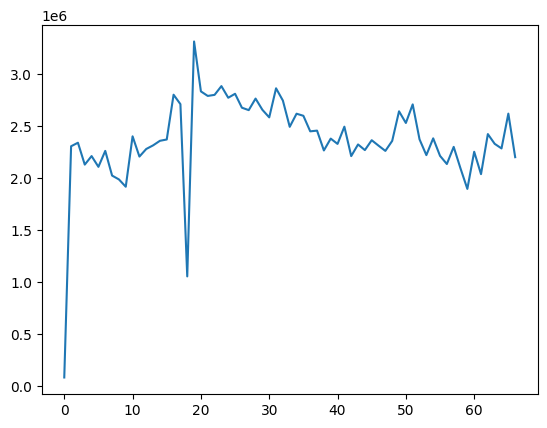

In [207]:
model['quantity'].plot()

## Autocorrelation

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are tools used in time series analysis to understand the autocorrelation of a time series. Autocorrelation refers to the correlation of a variable with itself over time, i.e., the correlation between a value and the lagged version of itself.

The ACF plot shows the correlation of a time series with its lagged values. Specifically, it shows the correlation coefficient between the values of the time series at lag k and the values at lag 0. A high correlation coefficient at a particular lag suggests that the values at that lag are related to the current value.

The PACF plot, on the other hand, shows the correlation between the time series and its lagged values while controlling for the values at other lags. In other words, it shows the correlation coefficient between the values of the time series at lag k and the values at lag 0, with the effect of lags 1 to k-1 removed.

Both the ACF and PACF plots can be used to identify the order of autoregressive (AR) and moving average (MA) processes, which are common models used in time series analysis.

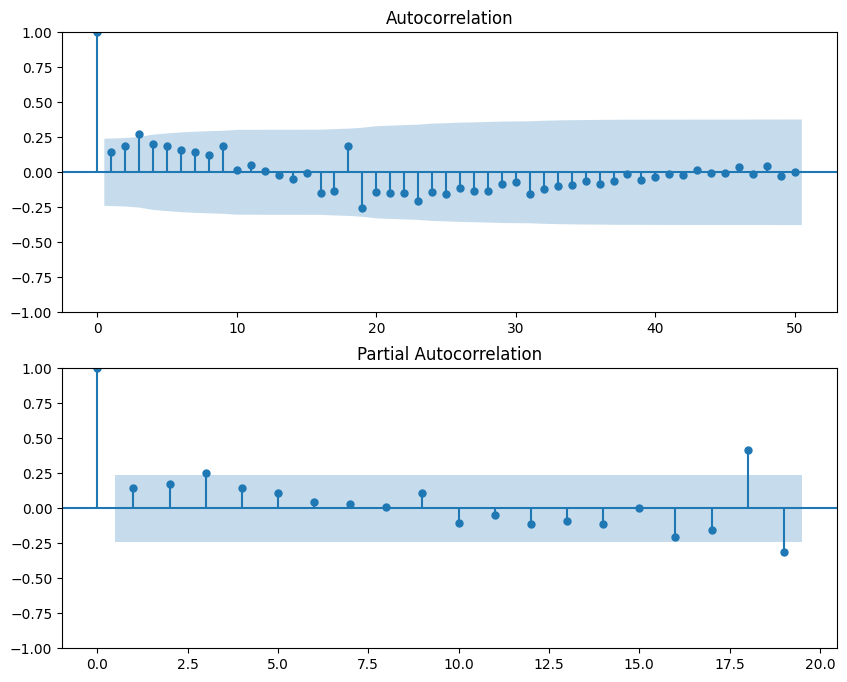

In [259]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))
acf_plot = plot_acf(model['quantity'], lags=50, ax=ax[0])
pacf_plot= plot_pacf(model['quantity'],  ax=ax[1])
plt.show()

Based on the ACF plot, the order for moving average that can be used are 0 and 3

Based on the PACF plot, the order for AutoRegressive that can be used are 0,3,18,19

## Forecasting

After we get all the information needed, we may move to make the forecasting model. In this model, we will use ARIMA (Autoregressive Integrated Moving Average).

ARIMA models are commonly used for stationary time series data, where the statistical properties of the data do not change over time. ARIMA models use autoregression, moving average, and differencing techniques to model the time series data and make predictions for future time points. The order of the autoregressive, moving average, and differencing terms in the model can be determined through techniques such as the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.

In summary, for a stationary time series with no seasonality, an ARIMA model is a good starting point for modeling and forecasting. However, selecting the best model may require testing multiple models and comparing their performance on hold-out data.

## Initial Model

Now, we want to create a forecasting model for predicting sales 4 weeks / 1 month ahead. I will split the "data_a1" into training and testing sets, with the first 50 data points being used for training and the remaining 17 data points being used for testing. The variable "frequency" is set to 7, indicating that the time series data has a weekly frequency.

Next, we create a ARIMA model and fits it to the training data. The order of the ARIMA model is set to (0, 1, 0), while the seasonal order is set to (0, 1, 2, frequency). These order number is the number we got from the exploration in the previous sections. The model is then used to generate predictions for the test data set and the next 15 time steps.

After we create the model, we calculate the model performance using the mean absolute percentage error (MAPE) and the mean absolute error (MAE).

Finally, we create plots the original time series data and the predicted values. The original data is shown in blue, while the predicted values are shown in orange. The x-axis shows the day number and the y-axis shows the value of the sales.

In [222]:
forecast = model.copy()
# Set the index to a range of integers
forecast.index = range(len(forecast))

forecast.head()


,week_end_date,quantity
0,2022-01-02,79292
1,2022-01-09,2302025
2,2022-01-16,2335968
3,2022-01-23,2125564
4,2022-01-30,2207480


In [227]:
forecast.shape

(67, 2)

MAPE : 0.07883554035926198
MAE : 187024.8330554671
RMSE : 222019.81834298145
R2Score : -21.409466908848238


c:\Users\appsg\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



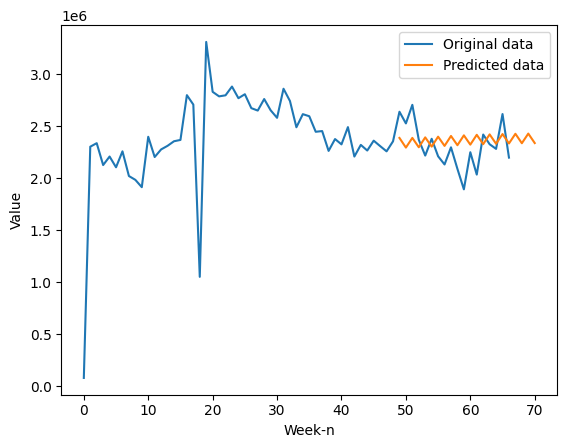

In [280]:
# Split the data_a1 into train and test sets
train = forecast['quantity'].iloc[:49]
test = forecast['quantity'].iloc[49:]

# Create and fit the ARIMA model
time = ARIMA(train, order=(3, 0, 3))
time_fit = time.fit()

# Generate predictions for the test set
predictions = time_fit.forecast(steps=len(test)+4)

# Evaluate the model performance
mape = mean_absolute_percentage_error(predictions[:18],test)
mae = mean_absolute_error(predictions[:18],test)
rmse = np.sqrt(mean_squared_error(predictions[:18],test))
r2score = r2_score(predictions[:18],test)
print(f'MAPE : {mape}')
print(f'MAE : {mae}')
print(f'RMSE : {rmse}')
print(f'R2Score : {r2score}')

# Plot the original data_a1 and the predicted values
plt.plot(forecast.index, forecast['quantity'], label='Original data')
plt.plot(predictions.index, predictions, label='Predicted data')
plt.legend()
plt.xlabel('Week-n')
plt.ylabel('Value')
plt.show()

Based on the provided metrics, the model may have good accuracy in terms of MAPE and MAE, but its performance may be questionable in terms of RMSE and R2Score.

The MAPE (Mean Absolute Percentage Error) value of 0.0788 suggests that, on average, the model's predictions are off by 7.88% of the actual value. This could be considered good or bad depending on the specific problem and industry standards.

The MAE (Mean Absolute Error) value of 187024.83 suggests that, on average, the model's predictions are off by 187,024.83 in absolute terms. Again, whether this is considered good or bad depends on the specific problem and industry standards.

However, the RMSE (Root Mean Square Error) value of 222019.82 suggests that the model's predictions may have high variance, and its R2Score of -21.41 suggests that the model is performing worse than a naive model that simply predicts the mean value of the dependent variable. These values indicate that the model may not be accurately capturing the underlying patterns in the data, and further investigation is warranted.

## Model Comparison

Though the model result according to MAPE result is pretty good with 7,88% score, we will do comparing the ARIMA model with SARIMA model to account it seasonal order

We will create the forecasting model using SARIMA (Seasonal AutoRegressive Integrated Moving Average). We will accounted the seasonal order of 2. Based on the original data plot, the graph is quite changing for every 2 weeks step.

c:\Users\appsg\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\appsg\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



MAPE : 0.0901719487030563
MAE : 208341.5095835567
RMSE : 253398.77147511378
R2Score : -3.669717592210543


c:\Users\appsg\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



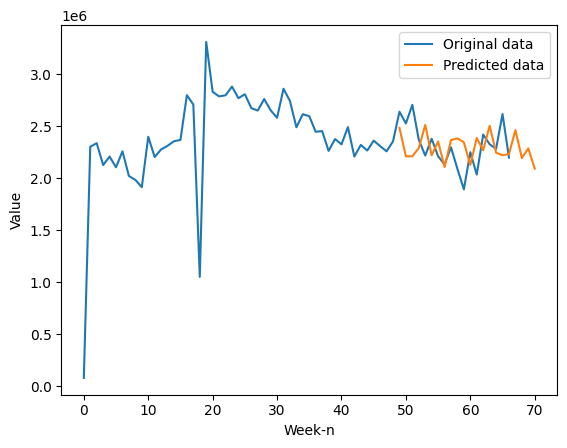

In [282]:
# Split the data_a1 into train and test sets
train = forecast['quantity'].iloc[:49]
test = forecast['quantity'].iloc[49:]

# Create and fit the ARIMA model
time_sar = SARIMAX(train, order=(3, 0, 3), seasonal_order=(3,0,3,7))
time_fit_sar = time_sar.fit()

# Generate predictions for the test set
predictions_sarima = time_fit_sar.forecast(steps=len(test)+4)

# Evaluate the model performance (MAPE & MAE)
mape = mean_absolute_percentage_error(predictions_sarima[:18],test)
mae = mean_absolute_error(predictions_sarima[:18],test)
rmse = np.sqrt(mean_squared_error(predictions_sarima[:18],test))
r2score = r2_score(predictions_sarima[:18],test)
print(f'MAPE : {mape}')
print(f'MAE : {mae}')
print(f'RMSE : {rmse}')
print(f'R2Score : {r2score}')

# Plot the original data_a1 and the predicted values
plt.plot(forecast.index, forecast['quantity'], label='Original data')
plt.plot(predictions_sarima.index, predictions_sarima, label='Predicted data')
plt.legend()
plt.xlabel('Week-n')
plt.ylabel('Value')
plt.show()

Based on the provided metrics, the model may have relatively high prediction errors.

The MAPE (Mean Absolute Percentage Error) value of 0.0902 suggests that, on average, the model's predictions are off by 9.02% of the actual value. Depending on the specific problem and industry standards, this could be considered high.

The MAE (Mean Absolute Error) value of 208341.51 suggests that, on average, the model's predictions are off by $208,341.51 in absolute terms. Again, whether this is considered good or bad depends on the specific problem and industry standards.

Furthermore, the RMSE (Root Mean Square Error) value of 253398.77 suggests that the model's predictions may have high variance, and its R2Score of -3.67 suggests that the model is performing worse than a naive model that simply predicts the mean value of the dependent variable. These values indicate that the model may not be accurately capturing the underlying patterns in the data, and further investigation is warranted.

## Conclusion

Based on the result from the ARIMA and SARIMA model, **I decided to go with the ARIMA model which naturally inclined with the given dataset which has no pattern of seasonality and is stationary.**

### Model Improvement

To improve the performance of the ARIMA model, there are several possible approaches:

Model Selection: It may be helpful to review the parameters used in the ARIMA model and try different combinations to see if they improve the performance of the model.

Data Preprocessing: It may be necessary to preprocess the data, such as removing outliers or identifying and addressing any missing or erroneous data.

Feature Engineering: It may be helpful to add additional features to the model, such as lagged variables or seasonal indicators, to better capture the patterns and trends in the data.

Model Evaluation: It is important to perform regular model evaluation to assess the performance of the model and identify areas for improvement. This may involve comparing the predicted values to the actual values, assessing the residuals for any patterns or biases, and comparing the performance of the model to other models.

Overall, improving the performance of an ARIMA model can be a complex task that requires careful consideration of the data, model parameters, and evaluation metrics. By exploring different approaches and techniques, it may be possible to develop a more accurate and reliable model.